<a href="https://colab.research.google.com/github/DKAbir111/Artificial-Intelligence/blob/main/201_15_14188_Custom_Cnn_on_KMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
import torch.nn as nn
import numpy as np
import torchvision #use for computer vision. It has also include dataset, model and image transformation.
import torchvision.transforms as transforms
from torchvision import datasets
from torchsummary import summary #provides a summary of a PyTorch model's architecture
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomCrop, ColorJitter, GaussianBlur, RandomVerticalFlip

# **Checking whether GPU is available**

In [28]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [29]:
#Hyper parameter- a hyperparameter that you can tune.
batch_size = 64 #The batch size is the number of training examples utilized in one iteration.
num_classes = 10 #num_classes is used to determine the number of output neurons in the final fully connected layer
learning_rate = 0.001 #It's a scalar value that determines the size of the steps taken during optimization.
num_epochs = 3 #he num_epochs variable typically represents the number of times the learning algorithm will work through the entire training dataset.

In [30]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

# **Dlownloading train data set**

In [31]:
train_df=torchvision.datasets.KMNIST('./data',train=True,download=True,transform=transform)

**Creating trainloader**

In [32]:
train_df_load=torch.utils.data.DataLoader(train_df,batch_size=64,shuffle=True)

**Checking length train data set**

In [33]:
print(len(train_df))
print(len(train_df_load))

60000
938


# **Downloading test data set**

In [34]:
test_df=torchvision.datasets.KMNIST('./data',train=False,transform=transform)

**Creating testloader**

In [35]:
test_df_load=torch.utils.data.DataLoader(test_df,batch_size=64)

**Checking the lenght of lest loader**

In [36]:
print(len(test_df))
print(len(test_df_load))

10000
157


**Print the shape**

In [37]:
for X,y in train_df_load:
    print(X.shape)
    break

torch.Size([64, 1, 227, 227])


In [38]:
for X,y in test_df_load:
    print(X.shape)
    break

torch.Size([64, 1, 227, 227])


# **Custom CNN model**

In [39]:
# Definition of a neural network model for KMNIST classification
class KMNIST_Net(nn.Module):
    def __init__(self):
        super(KMNIST_Net, self).__init__()

        # Convolutional layers with batch normalization and max pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)

        # Fully connected layers with dropout for regularization
        self.fc1 = nn.Linear(256, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        # Forward pass through convolutional and pooling layers
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Global average pooling instead of flattening
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        # Forward pass through fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        # Final fully connected layer for classification
        x = self.fc4(x)
        return x


In [40]:
# Create an instance of the model
model = KMNIST_Net().to(device)

# Print the model architecture
print(model)

KMNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

# Model parameter

In [41]:
for name, param in model.named_parameters(): #model parameter name and values
    if param.requires_grad:
        print(name, param.data)

conv1.weight tensor([[[[ 0.2350,  0.1797, -0.1889],
          [-0.1936,  0.0360,  0.2888],
          [-0.2663,  0.0512, -0.0691]]],


        [[[-0.1227, -0.1566,  0.1207],
          [-0.1698, -0.1967, -0.0393],
          [ 0.0680,  0.0668,  0.0127]]],


        [[[-0.3169, -0.0903,  0.0059],
          [ 0.1320, -0.0138,  0.1476],
          [-0.2960,  0.3149,  0.0574]]],


        [[[ 0.1711, -0.1367, -0.0459],
          [ 0.3316, -0.2101, -0.0696],
          [ 0.1675,  0.0015, -0.1446]]],


        [[[-0.0582, -0.2195, -0.1772],
          [ 0.0808, -0.2461,  0.1024],
          [ 0.1190, -0.1632,  0.1455]]],


        [[[ 0.3272,  0.2241,  0.2964],
          [ 0.1772, -0.2674,  0.0258],
          [-0.2479,  0.2354,  0.0561]]],


        [[[-0.0115, -0.0717, -0.0108],
          [ 0.1302, -0.0950, -0.1946],
          [ 0.1855,  0.0977,  0.2978]]],


        [[[-0.2201,  0.1176,  0.1752],
          [-0.2752,  0.1763,  0.2361],
          [-0.2924,  0.1020, -0.2478]]],


        [[[-0.0926,

# Loss function and optimizer

In [42]:
criterion = nn.CrossEntropyLoss()#for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001) #to adjust learning rate dynamically

# **Training and Validation**

In [43]:
# Setting the number of training epochs
epochs = 3

# Loop over the specified number of epochs
for epoch in range(epochs):
    # Set the model to training mode
    model.train()

    # Initialize running loss for the epoch
    running_loss = 0.0

    # Iterate over the training data loader
    for inputs, labels in train_df_load:
        # Move inputs and labels to the specified device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients to avoid accumulation
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(inputs)

        # Calculate the loss using the specified criterion
        loss = criterion(outputs, labels)

        # Backward pass to compute gradients
        loss.backward()

        # Update the model's weights using the optimizer
        optimizer.step()

        # Accumulate the running loss for the epoch
        running_loss += loss.item()

    # Print the average loss for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_df_load)}")


Epoch 1/3, Loss: 1.6024239694258806
Epoch 2/3, Loss: 0.8975149632008599
Epoch 3/3, Loss: 0.6139000366999905


# Testing and Evaluation

In [47]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():
    # Iterate over the test data loader
    for inputs, labels in test_df_load:
        # Move inputs and labels to the specified device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs)

        # Extract predicted labels by finding the index of the maximum output value
        _, preds = torch.max(outputs, 1)

        # Extend the lists with the predicted and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [48]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.632


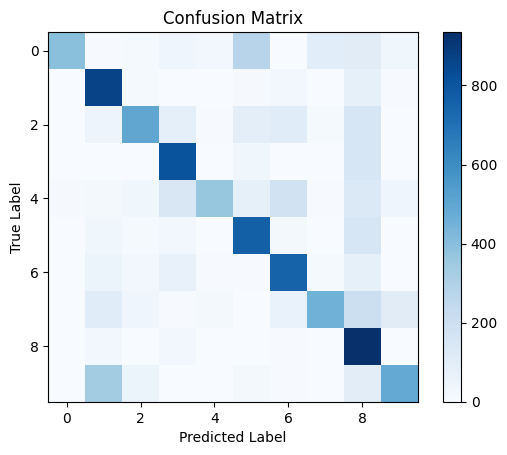

In [49]:
# Calculate the confusion matrix using the predicted and true labels
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix as an image with a blue colormap
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add title and colorbar
plt.title('Confusion Matrix')
plt.colorbar()

# Label the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()
